In [4]:
import shap
import optuna
from sklearn import set_config
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

In [5]:
set_config(transform_output="pandas") 

In [6]:
# load the data

data = fetch_california_housing(as_frame=True)

In [7]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [8]:
# make X and y

X, y = data.data, data.target

In [9]:
# columns names

feature_names = data.feature_names

feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [10]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [11]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [12]:
X.shape

(20640, 8)

In [13]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of Training data: ", X_train.shape)
print("Shape of Testing data: ", X_test.shape)

Shape of Training data:  (16512, 8)
Shape of Testing data:  (4128, 8)


In [14]:
# model 
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42,
                         n_jobs=-1, learning_rate=0.2, n_estimators=200,
                         reg_lambda=50, max_depth=7, gamma=0.05)

In [15]:
# fit the training data
xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [16]:
# claculate the predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

# calculate the RMSE and R2 score
rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2899, R2: 0.9371
Test RMSE: 0.4474, R2: 0.8472


In [17]:
# tune the model

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'gamma': trial.suggest_float('gamma', 0, 2),
        "subsample": trial.suggest_float('subsample', 0.7, 1.0),
        "n_jobs": -1,
        'objective': 'reg:squarederror',
        'random_state': 42
    }
    
    # set the model with the parameters
    model = XGBRegressor()
    
    model.set_params(**params)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict the test data
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    return r2

In [18]:
# create a study
study = optuna.create_study(direction='maximize')

study.optimize(func=objective, n_trials=50, show_progress_bar=True, n_jobs=-1)

[I 2026-03-01 13:33:29,790] A new study created in memory with name: no-name-68ea44f6-7c11-4bc2-8911-a8dd3049ef71
Best trial: 2. Best value: 0.778771:   2%|▏         | 1/50 [00:00<00:30,  1.62it/s]

[I 2026-03-01 13:33:30,434] Trial 2 finished with value: 0.7787711298513553 and parameters: {'learning_rate': 0.08733668506943607, 'n_estimators': 128, 'max_depth': 3, 'reg_lambda': 71.09589787271194, 'gamma': 0.6857095488345981, 'subsample': 0.7462549484391059}. Best is trial 2 with value: 0.7787711298513553.


Best trial: 0. Best value: 0.827052:   6%|▌         | 3/50 [00:01<00:14,  3.24it/s]

[I 2026-03-01 13:33:30,714] Trial 4 finished with value: 0.775263033444026 and parameters: {'learning_rate': 0.049194883851819984, 'n_estimators': 64, 'max_depth': 7, 'reg_lambda': 41.83599554617049, 'gamma': 0.059130744553286485, 'subsample': 0.9133186868904839}. Best is trial 2 with value: 0.7787711298513553.
[I 2026-03-01 13:33:30,892] Trial 0 finished with value: 0.8270516430206736 and parameters: {'learning_rate': 0.22600695180832062, 'n_estimators': 240, 'max_depth': 7, 'reg_lambda': 3.3298582543606305, 'gamma': 0.8700928979997922, 'subsample': 0.713748715513438}. Best is trial 0 with value: 0.8270516430206736.


Best trial: 7. Best value: 0.831471:   8%|▊         | 4/50 [00:01<00:12,  3.82it/s]

[I 2026-03-01 13:33:31,080] Trial 7 finished with value: 0.8314714498194333 and parameters: {'learning_rate': 0.25008402528551177, 'n_estimators': 304, 'max_depth': 7, 'reg_lambda': 74.32781018568835, 'gamma': 0.7724989808498501, 'subsample': 0.9024339268840303}. Best is trial 7 with value: 0.8314714498194333.


Best trial: 1. Best value: 0.838617:  14%|█▍        | 7/50 [00:01<00:07,  6.11it/s]

[I 2026-03-01 13:33:31,291] Trial 1 finished with value: 0.8386166318008696 and parameters: {'learning_rate': 0.18799160586794883, 'n_estimators': 110, 'max_depth': 10, 'reg_lambda': 28.844425511931387, 'gamma': 0.3120767356258647, 'subsample': 0.7446597637862279}. Best is trial 1 with value: 0.8386166318008696.
[I 2026-03-01 13:33:31,384] Trial 5 finished with value: 0.8325451303734258 and parameters: {'learning_rate': 0.2786361786573763, 'n_estimators': 462, 'max_depth': 8, 'reg_lambda': 50.9222759909755, 'gamma': 0.5199021012612295, 'subsample': 0.9436924089070362}. Best is trial 1 with value: 0.8386166318008696.
[I 2026-03-01 13:33:31,465] Trial 9 finished with value: 0.8028908551249604 and parameters: {'learning_rate': 0.16406544976769932, 'n_estimators': 198, 'max_depth': 3, 'reg_lambda': 38.45359525709025, 'gamma': 1.520342472217824, 'subsample': 0.8496811323873426}. Best is trial 1 with value: 0.8386166318008696.
[I 2026-03-01 13:33:31,476] Trial 3 finished with value: 0.831280

Best trial: 6. Best value: 0.843141:  22%|██▏       | 11/50 [00:01<00:03, 11.89it/s]

[I 2026-03-01 13:33:31,500] Trial 6 finished with value: 0.8431411844381235 and parameters: {'learning_rate': 0.23477946144885753, 'n_estimators': 100, 'max_depth': 10, 'reg_lambda': 22.330231459138894, 'gamma': 0.06715770897507034, 'subsample': 0.7822358893142913}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:31,515] Trial 8 finished with value: 0.8386653436211662 and parameters: {'learning_rate': 0.23485531279778027, 'n_estimators': 124, 'max_depth': 10, 'reg_lambda': 11.737049258422557, 'gamma': 0.26030220977357343, 'subsample': 0.8125803776023428}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:31,582] Trial 10 finished with value: 0.8018058071365806 and parameters: {'learning_rate': 0.18441573080156312, 'n_estimators': 114, 'max_depth': 3, 'reg_lambda': 25.943176362146218, 'gamma': 0.18430769882802167, 'subsample': 0.9607016637078727}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 6. Best value: 0.843141:  26%|██▌       | 13/50 [00:02<00:06,  5.66it/s]

[I 2026-03-01 13:33:32,289] Trial 18 finished with value: 0.8129495610086525 and parameters: {'learning_rate': 0.2995010356482246, 'n_estimators': 186, 'max_depth': 10, 'reg_lambda': 2.0991894092506413, 'gamma': 1.4959337444114382, 'subsample': 0.7963798967177431}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:32,374] Trial 16 finished with value: 0.8141841384177666 and parameters: {'learning_rate': 0.2793134530344776, 'n_estimators': 323, 'max_depth': 6, 'reg_lambda': 1.9704366141362712, 'gamma': 1.1639496058277792, 'subsample': 0.969629374916348}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 6. Best value: 0.843141:  34%|███▍      | 17/50 [00:02<00:03,  8.30it/s]

[I 2026-03-01 13:33:32,500] Trial 12 finished with value: 0.8175968678705106 and parameters: {'learning_rate': 0.2769062981035361, 'n_estimators': 422, 'max_depth': 9, 'reg_lambda': 24.928515535420225, 'gamma': 1.9271017391294065, 'subsample': 0.8994746778180064}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:32,517] Trial 15 finished with value: 0.8349676307731557 and parameters: {'learning_rate': 0.2535890394066378, 'n_estimators': 158, 'max_depth': 7, 'reg_lambda': 66.00295990582434, 'gamma': 0.6695909294965969, 'subsample': 0.7956612143545891}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:32,628] Trial 17 finished with value: 0.8141488737835925 and parameters: {'learning_rate': 0.13857857175783111, 'n_estimators': 340, 'max_depth': 5, 'reg_lambda': 20.76658260782775, 'gamma': 1.3624102504542976, 'subsample': 0.9900172979234738}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:32,629] Trial 13 finished with value: 0.81

Best trial: 6. Best value: 0.843141:  38%|███▊      | 19/50 [00:03<00:04,  7.74it/s]

[I 2026-03-01 13:33:32,860] Trial 19 finished with value: 0.815846057540505 and parameters: {'learning_rate': 0.12439539890909428, 'n_estimators': 52, 'max_depth': 9, 'reg_lambda': 18.837860663163877, 'gamma': 1.9252673108925338, 'subsample': 0.8018363404700257}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:32,942] Trial 20 finished with value: 0.817442486262999 and parameters: {'learning_rate': 0.13103129083919393, 'n_estimators': 57, 'max_depth': 9, 'reg_lambda': 19.966457909172775, 'gamma': 1.9380196506741465, 'subsample': 0.7940078817289299}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 6. Best value: 0.843141:  38%|███▊      | 19/50 [00:03<00:04,  7.74it/s]

[I 2026-03-01 13:33:33,073] Trial 21 finished with value: 0.8183018204958633 and parameters: {'learning_rate': 0.13013562413329355, 'n_estimators': 50, 'max_depth': 9, 'reg_lambda': 99.90850247788012, 'gamma': 0.43081193460677014, 'subsample': 0.8006086082929392}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 6. Best value: 0.843141:  44%|████▍     | 22/50 [00:03<00:03,  7.30it/s]

[I 2026-03-01 13:33:33,288] Trial 22 finished with value: 0.8289680581628898 and parameters: {'learning_rate': 0.11241405164057486, 'n_estimators': 55, 'max_depth': 9, 'reg_lambda': 16.327448754871998, 'gamma': 0.4139884689338702, 'subsample': 0.8001106740407853}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:33,400] Trial 24 finished with value: 0.8334668862932051 and parameters: {'learning_rate': 0.20991120509313282, 'n_estimators': 60, 'max_depth': 9, 'reg_lambda': 99.74502644207973, 'gamma': 0.37502588014371346, 'subsample': 0.8153774615868652}. Best is trial 6 with value: 0.8431411844381235.
[I 2026-03-01 13:33:33,480] Trial 23 finished with value: 0.8331652213652854 and parameters: {'learning_rate': 0.20650920622363095, 'n_estimators': 55, 'max_depth': 9, 'reg_lambda': 15.647420218489442, 'gamma': 0.34288194548594375, 'subsample': 0.7993726350827427}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 6. Best value: 0.843141:  48%|████▊     | 24/50 [00:04<00:05,  5.16it/s]

[I 2026-03-01 13:33:34,012] Trial 26 finished with value: 0.8368462039737543 and parameters: {'learning_rate': 0.20218276470252636, 'n_estimators': 237, 'max_depth': 10, 'reg_lambda': 10.83268675789099, 'gamma': 0.4436107299682689, 'subsample': 0.8732470858198711}. Best is trial 6 with value: 0.8431411844381235.


Best trial: 14. Best value: 0.846911:  50%|█████     | 25/50 [00:04<00:05,  4.90it/s]

[I 2026-03-01 13:33:34,260] Trial 14 finished with value: 0.8469109711059761 and parameters: {'learning_rate': 0.09740469231818705, 'n_estimators': 330, 'max_depth': 6, 'reg_lambda': 54.37505375915745, 'gamma': 0.04531876628295728, 'subsample': 0.7543895383394629}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  52%|█████▏    | 26/50 [00:04<00:04,  4.89it/s]

[I 2026-03-01 13:33:34,467] Trial 25 finished with value: 0.84133707067349 and parameters: {'learning_rate': 0.20444804407871525, 'n_estimators': 249, 'max_depth': 10, 'reg_lambda': 97.20371836885323, 'gamma': 0.4112689423675596, 'subsample': 0.8363005661292455}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  56%|█████▌    | 28/50 [00:05<00:04,  4.93it/s]

[I 2026-03-01 13:33:34,690] Trial 28 finished with value: 0.8429069679101642 and parameters: {'learning_rate': 0.1905155953189163, 'n_estimators': 114, 'max_depth': 10, 'reg_lambda': 36.57388114760609, 'gamma': 0.2587205623525629, 'subsample': 0.752319487514786}. Best is trial 14 with value: 0.8469109711059761.
[I 2026-03-01 13:33:34,877] Trial 29 finished with value: 0.8451481021102013 and parameters: {'learning_rate': 0.19547038182643017, 'n_estimators': 116, 'max_depth': 10, 'reg_lambda': 38.236798868563014, 'gamma': 0.21935394138671593, 'subsample': 0.7553048186670788}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  58%|█████▊    | 29/50 [00:05<00:04,  4.27it/s]

[I 2026-03-01 13:33:35,188] Trial 30 finished with value: 0.8416020008540276 and parameters: {'learning_rate': 0.1941267566258079, 'n_estimators': 115, 'max_depth': 10, 'reg_lambda': 36.083258371714585, 'gamma': 0.04538720265920193, 'subsample': 0.7580635223749248}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  60%|██████    | 30/50 [00:05<00:04,  4.00it/s]

[I 2026-03-01 13:33:35,484] Trial 27 finished with value: 0.8395991192975187 and parameters: {'learning_rate': 0.20727840409580672, 'n_estimators': 241, 'max_depth': 10, 'reg_lambda': 10.019165728468161, 'gamma': 0.03035698292582866, 'subsample': 0.8768639733818978}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  62%|██████▏   | 31/50 [00:06<00:05,  3.58it/s]

[I 2026-03-01 13:33:35,840] Trial 32 finished with value: 0.8080793561990227 and parameters: {'learning_rate': 0.03605748181494212, 'n_estimators': 239, 'max_depth': 5, 'reg_lambda': 58.92397268500412, 'gamma': 0.016262397675038794, 'subsample': 0.7670519564963743}. Best is trial 14 with value: 0.8469109711059761.
[I 2026-03-01 13:33:35,929] Trial 31 finished with value: 0.8443222349867323 and parameters: {'learning_rate': 0.17276081211154273, 'n_estimators': 119, 'max_depth': 10, 'reg_lambda': 33.758422717810575, 'gamma': 0.004627071291596188, 'subsample': 0.7554836589444708}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 14. Best value: 0.846911:  68%|██████▊   | 34/50 [00:06<00:03,  4.43it/s]

[I 2026-03-01 13:33:36,265] Trial 33 finished with value: 0.8304395264460094 and parameters: {'learning_rate': 0.06330838139123615, 'n_estimators': 272, 'max_depth': 5, 'reg_lambda': 54.12515785837632, 'gamma': 0.03945614423432863, 'subsample': 0.76927583821873}. Best is trial 14 with value: 0.8469109711059761.
[I 2026-03-01 13:33:36,418] Trial 34 finished with value: 0.8011026794146265 and parameters: {'learning_rate': 0.024742486355646548, 'n_estimators': 282, 'max_depth': 5, 'reg_lambda': 53.772608713715215, 'gamma': 0.004918483941989127, 'subsample': 0.7008814518160298}. Best is trial 14 with value: 0.8469109711059761.


Best trial: 11. Best value: 0.849771:  70%|███████   | 35/50 [00:07<00:04,  3.64it/s]

[I 2026-03-01 13:33:36,832] Trial 11 finished with value: 0.8497711763521949 and parameters: {'learning_rate': 0.04695755124710933, 'n_estimators': 458, 'max_depth': 10, 'reg_lambda': 89.0832227301601, 'gamma': 0.18570792165194772, 'subsample': 0.9141562196863035}. Best is trial 11 with value: 0.8497711763521949.
[I 2026-03-01 13:33:36,841] Trial 36 finished with value: 0.8263498810011516 and parameters: {'learning_rate': 0.07204862794071949, 'n_estimators': 274, 'max_depth': 5, 'reg_lambda': 48.911043726228385, 'gamma': 0.9883252127465881, 'subsample': 0.7194919814068018}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  76%|███████▌  | 38/50 [00:07<00:02,  4.81it/s]

[I 2026-03-01 13:33:37,122] Trial 35 finished with value: 0.8395748718043796 and parameters: {'learning_rate': 0.07338005009880849, 'n_estimators': 358, 'max_depth': 5, 'reg_lambda': 47.44878429098294, 'gamma': 0.08810772550016496, 'subsample': 0.7212903786266064}. Best is trial 11 with value: 0.8497711763521949.
[I 2026-03-01 13:33:37,293] Trial 37 finished with value: 0.7961913371834667 and parameters: {'learning_rate': 0.022938636871857127, 'n_estimators': 284, 'max_depth': 5, 'reg_lambda': 54.128097643326996, 'gamma': 1.04949035859497, 'subsample': 0.7061974733053108}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  80%|████████  | 40/50 [00:07<00:01,  5.19it/s]

[I 2026-03-01 13:33:37,457] Trial 38 finished with value: 0.8491806324239717 and parameters: {'learning_rate': 0.1667433347744553, 'n_estimators': 168, 'max_depth': 8, 'reg_lambda': 52.38432216758884, 'gamma': 0.1877452131997156, 'subsample': 0.7044899055929207}. Best is trial 11 with value: 0.8497711763521949.
[I 2026-03-01 13:33:37,638] Trial 39 finished with value: 0.8469855508837919 and parameters: {'learning_rate': 0.17117847209505765, 'n_estimators': 173, 'max_depth': 8, 'reg_lambda': 47.09520063100962, 'gamma': 0.15186248803439625, 'subsample': 0.7134824008429941}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  82%|████████▏ | 41/50 [00:08<00:02,  4.33it/s]

[I 2026-03-01 13:33:37,968] Trial 40 finished with value: 0.8454620567683964 and parameters: {'learning_rate': 0.16484736603269146, 'n_estimators': 159, 'max_depth': 8, 'reg_lambda': 47.01723197882228, 'gamma': 0.1757659204415341, 'subsample': 0.7056561567470369}. Best is trial 11 with value: 0.8497711763521949.
[I 2026-03-01 13:33:37,996] Trial 41 finished with value: 0.8446273303803964 and parameters: {'learning_rate': 0.1632999911856714, 'n_estimators': 158, 'max_depth': 8, 'reg_lambda': 32.05560058044077, 'gamma': 0.1896056837595977, 'subsample': 0.7274064231120079}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  86%|████████▌ | 43/50 [00:09<00:03,  2.29it/s]

[I 2026-03-01 13:33:39,374] Trial 48 finished with value: 0.8377461081951528 and parameters: {'learning_rate': 0.10267533956941226, 'n_estimators': 157, 'max_depth': 8, 'reg_lambda': 83.69993472013823, 'gamma': 0.5813603535455057, 'subsample': 0.7260827693644121}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  88%|████████▊ | 44/50 [00:09<00:02,  2.50it/s]

[I 2026-03-01 13:33:39,642] Trial 43 finished with value: 0.8416579863138662 and parameters: {'learning_rate': 0.09693840682959963, 'n_estimators': 495, 'max_depth': 8, 'reg_lambda': 88.64359383416114, 'gamma': 0.5629874517084332, 'subsample': 0.7341500506551123}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  92%|█████████▏| 46/50 [00:10<00:01,  3.09it/s]

[I 2026-03-01 13:33:39,982] Trial 46 finished with value: 0.8404660494221142 and parameters: {'learning_rate': 0.10084383113218456, 'n_estimators': 455, 'max_depth': 8, 'reg_lambda': 85.76115092262168, 'gamma': 0.609716936064288, 'subsample': 0.7271045969851048}. Best is trial 11 with value: 0.8497711763521949.
[I 2026-03-01 13:33:40,144] Trial 47 finished with value: 0.8396108672128777 and parameters: {'learning_rate': 0.09228984983196728, 'n_estimators': 469, 'max_depth': 8, 'reg_lambda': 82.73226666223047, 'gamma': 0.6507979568319979, 'subsample': 0.7274688957931561}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 11. Best value: 0.849771:  92%|█████████▏| 46/50 [00:10<00:01,  3.09it/s]

[I 2026-03-01 13:33:40,195] Trial 49 finished with value: 0.8428096447242563 and parameters: {'learning_rate': 0.11513129752426321, 'n_estimators': 494, 'max_depth': 8, 'reg_lambda': 44.94555875867374, 'gamma': 0.5839108006400959, 'subsample': 0.7349064150827624}. Best is trial 11 with value: 0.8497711763521949.


Best trial: 44. Best value: 0.852104:  98%|█████████▊| 49/50 [00:10<00:00,  4.51it/s]

[I 2026-03-01 13:33:40,460] Trial 42 finished with value: 0.8501107031319718 and parameters: {'learning_rate': 0.08865674342350943, 'n_estimators': 489, 'max_depth': 8, 'reg_lambda': 44.87206288020303, 'gamma': 0.18787354623830504, 'subsample': 0.7263120477471695}. Best is trial 42 with value: 0.8501107031319718.
[I 2026-03-01 13:33:40,586] Trial 44 finished with value: 0.8521035033331037 and parameters: {'learning_rate': 0.09492470647986159, 'n_estimators': 488, 'max_depth': 8, 'reg_lambda': 89.9598045368175, 'gamma': 0.19883763091344886, 'subsample': 0.7286326061495147}. Best is trial 44 with value: 0.8521035033331037.


Best trial: 44. Best value: 0.852104: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]

[I 2026-03-01 13:33:40,686] Trial 45 finished with value: 0.8509327388667017 and parameters: {'learning_rate': 0.09597491832600044, 'n_estimators': 500, 'max_depth': 8, 'reg_lambda': 86.62783656698136, 'gamma': 0.17997391163360685, 'subsample': 0.7267596999540479}. Best is trial 44 with value: 0.8521035033331037.


In [19]:
# get the best parameters
study.best_params

{'learning_rate': 0.09492470647986159,
 'n_estimators': 488,
 'max_depth': 8,
 'reg_lambda': 89.9598045368175,
 'gamma': 0.19883763091344886,
 'subsample': 0.7286326061495147}

In [20]:
# get the best value
study.best_value

0.8521035033331037

In [21]:
# get the best estimator
best_model = XGBRegressor(**study.best_params)

best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [22]:
# print the metrics
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

rmse_train = root_mean_squared_error(y_train, y_pred_train)
rmse_test = root_mean_squared_error(y_test, y_pred_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.4f}, R2: {r2_train:.4f}")
print(f"Test RMSE: {rmse_test:.4f}, R2: {r2_test:.4f}")

Train RMSE: 0.2944, R2: 0.9352
Test RMSE: 0.4406, R2: 0.8518


In [23]:
best_model


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [24]:
# create the tree explainer

explainer = shap.TreeExplainer(model=best_model,
                               data=X_train)

In [26]:
explainer.expected_value     #calculates the base value

np.float64(2.006942263994373)

In [27]:
# calculate the shap values for all test data

shap_values = explainer(X_test)

 99%|===================| 4096/4128 [01:20<00:00]        

In [28]:
shap_values.shape

(4128, 8)

In [29]:
len(feature_names)

8

In [30]:
feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [31]:
shap_values[0:5]

.values =
array([[-3.64906957e-01,  4.73979183e-03, -1.30586210e-01,
         1.46189564e-02, -2.05674324e-02, -2.15903670e-01,
        -6.87117537e-01, -5.07226993e-02],
       [-3.40617948e-01,  2.25762543e-02, -1.04109643e-01,
         2.25601143e-02,  6.87500265e-03, -6.11649377e-02,
        -7.29271597e-01,  2.78181882e-02],
       [ 1.26828888e-01,  3.77551030e-01, -4.23883920e-02,
         6.14828151e-02, -1.33276062e-03,  7.91674844e-01,
         2.57193705e-01,  1.49765615e+00],
       [ 4.32132039e-01,  2.32303968e-02,  1.86144595e-01,
         1.58093271e-03,  1.55020442e-02, -3.27472856e-01,
         1.48526372e-01,  6.74916560e-02],
       [-3.45775174e-02, -1.16873902e-02, -1.21063895e-02,
         4.74613445e-03,  4.12934309e-03, -1.31805400e-02,
        -4.35264995e-01,  8.91038330e-01]])

.base_values =
array([2.00694226, 2.00694226, 2.00694226, 2.00694226, 2.00694226])

.data =
array([[ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,
         1.02228412e+00,  1.3920

In [32]:
shap_values

.values =
array([[-3.64906957e-01,  4.73979183e-03, -1.30586210e-01, ...,
        -2.15903670e-01, -6.87117537e-01, -5.07226993e-02],
       [-3.40617948e-01,  2.25762543e-02, -1.04109643e-01, ...,
        -6.11649377e-02, -7.29271597e-01,  2.78181882e-02],
       [ 1.26828888e-01,  3.77551030e-01, -4.23883920e-02, ...,
         7.91674844e-01,  2.57193705e-01,  1.49765615e+00],
       ...,
       [ 1.70877839e+00, -1.39963027e-03,  3.65537119e-01, ...,
        -2.29493425e-03, -5.45865091e-02,  8.89059867e-01],
       [-2.82852136e-01, -3.84125679e-02, -5.93972263e-02, ...,
        -6.81611673e-03, -9.85479026e-01,  2.85124144e-02],
       [-6.89265427e-02, -1.48988336e-02, -2.42016116e-01, ...,
        -2.99133448e-01,  2.17886206e-01,  1.20631963e-01]],
      shape=(4128, 8))

.base_values =
array([2.00694226, 2.00694226, 2.00694226, ..., 2.00694226, 2.00694226,
       2.00694226], shape=(4128,))

.data =
array([[   1.6812    ,   25.        ,    4.19220056, ...,    3.87743733,
     

In [33]:
shap_values.shape

(4128, 8)

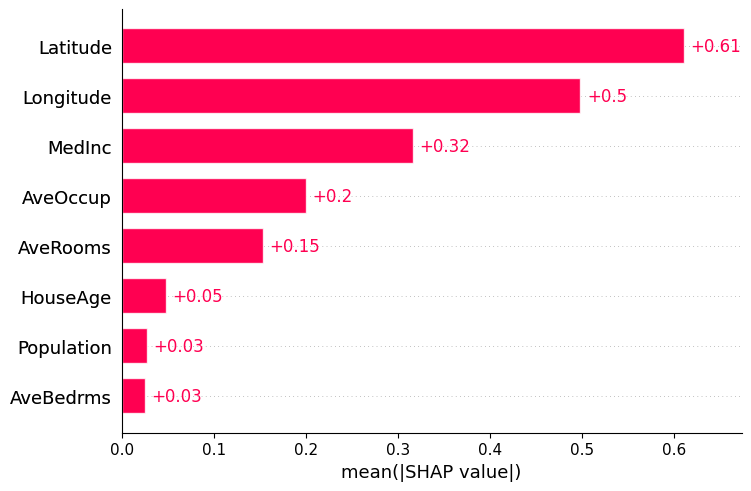

In [34]:
# bar plot to plot feature importance

shap.plots.bar(shap_values)